<a href="https://colab.research.google.com/github/IlyasMoutawwakil/ONNX-TrOCR/blob/main/Faster_TrOCR_with_ONNX%2BAutoRegressive_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So you want a faster TrOCR ? You're in the right place.

# Setup

In [1]:
#@title This should be taken into account because we are going to experiment with different configurations
#@markdown Lucky shot !! We got the A100-40GB xD
!nvidia-smi

Sat Oct 22 13:33:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    61W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Run this to pip install everything needed and wget an image with some text in it
%%capture

!pip install craft-text-detector
!pip install transformers
!pip install sentencepiece
!pip install onnxruntime-gpu
!pip install protobuf
!pip install torch
!pip install onnx

!wget https://www.t4help.uhi.ac.uk/t4-media/one-web/t4-help/landing-pages/content-type-text.JPG

In [2]:
#@title Detect some textlines to work our experiments on

%%capture

import cv2
from PIL import Image
from craft_text_detector import Craft

# set image path and export folder directory
filename = 'content-type-text.JPG'
image = cv2.imread(filename)

# create a craft instance
craft = Craft(crop_type="poly", cuda=True)

# apply craft text detection and export detected regions to output directory
prediction_result = craft.detect_text(image)

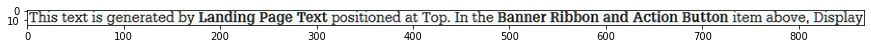

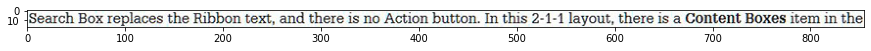

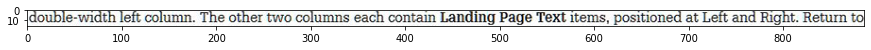

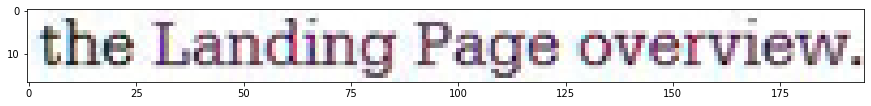

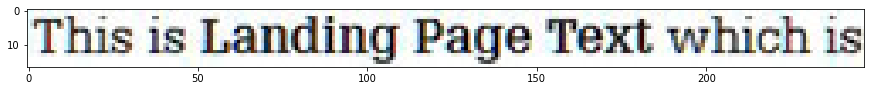

Number of textlines in total : 17


In [3]:
#@title Print some examples
#@markdown Notice that the length is usually not the same when working textlines coming from real scripts.

import matplotlib.pyplot as plt

textlines = []

for i,j in enumerate(prediction_result['boxes']): 
    roi = image[int(prediction_result['boxes'][i][0][1]): int(prediction_result['boxes'][i][2][1]), 
              int(prediction_result['boxes'][i][0][0]): int(prediction_result['boxes'][i][2][0])]
    textlines.append(Image.fromarray(roi).convert("RGB"))

    if i<5:
      plt.figure(figsize=(15, 60))
      plt.imshow(textlines[-1])
      plt.show()

print('Number of textlines in total :', len(textlines))

# HF model

In [4]:
#@title Create HF TrOCR models for both CPU and GPU

from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch

preprocessor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')

cuda_hf_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1').to('cuda')
cpu_hf_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1').to('cpu')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#@title Generation configuration

def configure_generation(model, beams=1):
    # model.config.decoder_start_token_id = preprocessor.tokenizer.cls_token_id # only if you're gonna train the model
    model.config.pad_token_id = model.config.decoder.pad_token_id = preprocessor.tokenizer.pad_token_id
    model.config.eos_token_id = model.config.decoder.eos_token_id = preprocessor.tokenizer.sep_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size
    # set beam search parameters
    model.config.decoder.early_stopping = True
    model.config.decoder.no_repeat_ngram_size = 3
    model.config.decoder.length_penalty = 2.0
    model.config.decoder.num_beams = beams

configure_generation(cuda_hf_model, 1)
configure_generation(cpu_hf_model, 1)

In [7]:
pixel_values = preprocessor.feature_extractor(
  textlines,
  return_tensors="pt"
).pixel_values

## HF Inference

In [11]:
%timeit preprocessor.tokenizer.batch_decode( \
                                            cuda_hf_model.generate( \
                                                                   pixel_values.to('cuda'), \
                                                                   max_length=96 \
                                                                   ), \
                                            skip_special_tokens=True \
                                            )

1.68 s ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%time preprocessor.tokenizer.batch_decode( \
                                          cpu_hf_model.generate( \
                                                                pixel_values.to('cpu'), \
                                                                max_length=96 \
                                                                ), \
                                          skip_special_tokens=True \
                                          )

CPU times: user 4min 7s, sys: 17.5 s, total: 4min 24s
Wall time: 44.8 s


['This text is generated by Landing Page Text positioned at Top. In the Banner Ribbon and Action Button item above, Display',
 'Search Box replaces the Ribbon text, and there is no Action button. In this 2-1-1 layout, there is a Content Butes item in the',
 'double-width left column. The other two columns each contain Landing Page Text items, positioned at Left and Right. Return to',
 'the Landing Page overview.',
 'This is Landing Page Text which is',
 'positioned at Right. It is automatically',
 'right-aligned.',
 'University of the Highlands and Islands',
 'Executive Office',
 '12b Ness Walk',
 'Inverness',
 'Scotland',
 'IV3 5SO',
 'Linking to Media Library documents, or',
 'to Sections is possible. The usual text',
 'formatting options are available in the',
 'toolbar.']

# Container models

In [12]:
import torch

class TrOCREncoder(torch.nn.Module):
    """ Creation of a class to output only the last hidden state from the encoder """

    def __init__(self, encoder, config):
        super().__init__()
        self.model = encoder
        self.config = config
        
    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

class TrOCRDecoder(torch.nn.Module):
    """ Creation of a class to combine the decoder and the lm head """

    def __init__(self, decoder, config):
        super().__init__()
        self.model = decoder
        self.config = config

    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs) # I tried unrolling the decoder but it didn't work

In [13]:
simplified_encoder = TrOCREncoder(cuda_hf_model.encoder, cuda_hf_model.encoder.config)
simplified_decoder = TrOCRDecoder(cuda_hf_model.decoder, cuda_hf_model.decoder.config)

# ONNXization

In [14]:
from pathlib import Path

with torch.no_grad():
    torch.onnx.export(
        simplified_encoder,
        args=torch.ones([64, 3, 384, 384]).to('cuda'),
        f=Path('/content/trocr_encoder.onnx'),
        opset_version=15,
        input_names=["pixel_values"],
        output_names=["last_hidden_state"],
        dynamic_axes={
            "pixel_values": {0:'batch'},
            "last_hidden_state": {0: 'batch'},
        },
        do_constant_folding=True,
    )

/usr/local/lib/python3.7/dist-packages/transformers/models/vit/modeling_vit.py:172: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.7/dist-packages/transformers/models/vit/modeling_vit.py:177: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [15]:
input_ids = torch.ones(64, 96, dtype=torch.int64).to('cuda')
attention_mask = torch.ones(64, 96, dtype=torch.int64).to('cuda')
encoder_hidden_states  = torch.ones([64, 577, 768]).to('cuda')

with torch.no_grad():
    torch.onnx.export(
        simplified_decoder,
        args=(input_ids, attention_mask, encoder_hidden_states),
        f=Path('/content/trocr_decoder.onnx'),
        opset_version=15,
        input_names=[
            "input_ids",
            "attention_mask",
            "encoder_hidden_states",
        ],
        output_names=["logits"],
        dynamic_axes={
            "input_ids": {0:'batch', 1:'sequence_length'},
            "attention_mask": {0:'batch', 1:'sequence_length'},
            "encoder_hidden_states": {0:'batch'},
            "logits": {0:'batch'},
        },
        do_constant_folding=True,
    )

/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:141: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.weights is None or max_pos > self.weights.size(0):
/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:526: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1:
/usr/local/lib/python3.7/dist-packages/transformers/models/trocr/modeling_trocr.py:53: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you 

In [16]:
onnx_models = (Path('/content/trocr_encoder.onnx'),
               Path('/content/trocr_decoder.onnx'))

# Quantization 
I guess some operations used in TrOCR are not implemented for quantization so let's just skip it.

In [18]:
# from onnxruntime.quantization import quantize_dynamic, QuantType
# from pathlib import Path

# def quantize(models_paths):
#     """
#     Quantize the weights of the model from float32 to in8 to allow very efficient inference on modern CPU
#     Uses unsigned ints for activation values, signed ints for weights, per
#     https://onnxruntime.ai/docs/performance/quantization.html#data-type-selection
#     it is faster on most CPU architectures
#     Args:
#         onnx_model_path: Path to location the exported ONNX model is stored
#     Returns: The Path generated for the quantized
#     """

#     quant_models_paths = []
#     for model_path in models_paths:
      
#         model_path = model_path.as_posix()
#         output_model_path = f"{model_path[:-5]}_quantized.onnx"
        
#         quantize_dynamic(
#             model_input=model_path,
#             model_output=output_model_path,
#             per_channel=True,
#             reduce_range=True, # should be the same as per_channel
#             weight_type=QuantType.QUInt8, # per docs, signed is faster on most CPUs
#             optimize_model=True,
#         )
#         quant_models_paths.append(output_model_path)

#     return tuple(quant_models_paths)

# quantized_models_paths = quantize(models_paths=onnx_models)
# quantized_models_paths

# ONNX Runtime Sessions

In [17]:
import os
from onnxruntime import (
    GraphOptimizationLevel,
    InferenceSession,
    SessionOptions,
    ExecutionMode,
)

def get_onnx_runtime_sessions(
    model_paths,
    default: bool = True,
    opt_level: int = 99,
    parallel_exe_mode: bool = True,
    provider=["TensorrtExecutionProvider", "CPUExecutionProvider", "CUDAExecutionProvider"]
):
    path_to_encoder, path_to_decoder = model_paths
    
    if default:
        encoder_sess = InferenceSession(str(path_to_encoder), providers=provider)
        decoder_sess = InferenceSession(str(path_to_decoder), providers=provider)
    else:
        # Few properties that might have an impact on performances
        options = SessionOptions()
        if opt_level == 1:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_BASIC
        elif opt_level == 2:
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_EXTENDED
        else:
            assert opt_level == 99
            options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

        # set this true for better performance
        if parallel_exe_mode == True:
            options.execution_mode = ExecutionMode.ORT_PARALLEL
        else:
            options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

        encoder_sess = InferenceSession(str(path_to_encoder), options, providers=provider)
        decoder_sess = InferenceSession(str(path_to_decoder), options, providers=provider)

    return encoder_sess, decoder_sess
  
cuda_encoder_sess, cuda_decoder_sess = get_onnx_runtime_sessions(
  model_paths=onnx_models,
  default=True,
  provider=['CUDAExecutionProvider']
)

cpu_encoder_sess, cpu_decoder_sess = get_onnx_runtime_sessions(
  model_paths=onnx_models,
  default=True,
  provider=['CPUExecutionProvider']
)

# Inference Models Testing

In [18]:
import torch
import numpy as np
from transformers.modeling_outputs import BaseModelOutput

class ONNXTrOCREncoder(torch.nn.Module):
    def __init__(self, encoder_sess, encoder_config={}):
        super().__init__()
        self.encoder = encoder_sess
        self.config = encoder_config
        self.main_input_name = 'pixel_values'

    def forward(
        self,
        pixel_values,
        *args, **kwargs
    ):
        last_hidden_state = torch.from_numpy(
            self.encoder.run(
                ["last_hidden_state"],
                {
                    "pixel_values": pixel_values.cpu().numpy(),
                },
            )[0])
        
        return BaseModelOutput(last_hidden_state=last_hidden_state)

cuda_onnx_encoder = ONNXTrOCREncoder(cuda_encoder_sess, cuda_hf_model.encoder.config)
cpu_onnx_encoder = ONNXTrOCREncoder(cpu_encoder_sess, cpu_hf_model.encoder.config)

hidden_state = cuda_onnx_encoder(torch.ones([2, 3, 384, 384]).to('cuda'))
hidden_state = cpu_onnx_encoder(torch.ones([2, 3, 384, 384]).to('cpu'))

hidden_state[0].shape

torch.Size([2, 577, 768])

In [19]:
from transformers.modeling_outputs import Seq2SeqLMOutput

class ONNXTrOCRDecoder(torch.nn.Module):
    def __init__(self, decoder_sess, decoder_config={}):
        super().__init__()
        self.decoder = decoder_sess
        self.config = decoder_config
    
    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, use_cache=None, **kwargs):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)

        return {
            "input_ids": input_ids,  # encoder_outputs is defined. input_ids not needed
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
        }
    
    def forward(self, input_ids, attention_mask, encoder_hidden_states, *args, **kwargs):
        decoder_outputs = torch.from_numpy(self.decoder.run(
            ["logits"],
            {
                "input_ids": input_ids.cpu().numpy(),
                "attention_mask": attention_mask.cpu().numpy(),
                "encoder_hidden_states": encoder_hidden_states.cpu().numpy(),
            },
        )[0])
        
        return Seq2SeqLMOutput(logits=decoder_outputs)

input_ids = torch.ones(2, 96, dtype=torch.int64)
attention_mask = torch.ones(2, 96, dtype=torch.int64)
encoder_hidden_states  = torch.ones([2, 577, 768]).to('cuda')

cuda_onnx_decoder = ONNXTrOCRDecoder(cuda_decoder_sess, cuda_hf_model.decoder.config)
cpu_onnx_decoder = ONNXTrOCRDecoder(cpu_decoder_sess, cpu_hf_model.decoder.config)

decoder_logits = cuda_onnx_decoder(input_ids.to('cuda'), 
                                   attention_mask.to('cuda'),
                                   encoder_hidden_states.to('cuda'))

decoder_logits = cpu_onnx_decoder(input_ids.to('cpu'), 
                                  attention_mask.to('cpu'),
                                  encoder_hidden_states.to('cpu'))

decoder_logits[0].shape

torch.Size([2, 96, 50265])

# Basic ONNX Inference

In [26]:
from transformers import AutoConfig

class ONNXTrOCR(VisionEncoderDecoderModel):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(model_path)
        super().__init__(config)
        
        encoder_sess, decoder_sess = onnx_model_sessions

        self.encoder = ONNXTrOCREncoder(encoder_sess)
        self.decoder = ONNXTrOCRDecoder(decoder_sess)

    def forward(
        self,
        pixel_values=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        encoder_hidden_states = encoder_outputs['last_hidden_state'] \
                                 if type(encoder_outputs)==dict \
                                 else encoder_outputs[0]

        # else:
        encoder_attention_mask = None
        
        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            use_cache=use_cache,
            past_key_values=past_key_values,
        )

        return Seq2SeqLMOutput(
            logits=decoder_outputs.logits,
        )

cuda_onnx_trocr = ONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(cuda_encoder_sess, cuda_decoder_sess)
    ).to('cuda')

cpu_onnx_trocr = ONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(cpu_encoder_sess, cpu_decoder_sess)
    ).to('cpu')

configure_generation(cuda_onnx_trocr)
configure_generation(cpu_onnx_trocr)

In [27]:
%timeit preprocessor.tokenizer.batch_decode( \
                                            cuda_onnx_trocr.generate( \
                                                                     pixel_values.to('cpu'), \
                                                                     max_length=96 \
                                                                     ), \
                                            skip_special_tokens=True, \
                                            )

1.95 s ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%time preprocessor.tokenizer.batch_decode( \
                                          cpu_onnx_trocr.generate( \
                                                                  pixel_values.to('cpu'), \
                                                                  max_length=96 \
                                                                  ), \
                                          skip_special_tokens=True, \
                                          )

CPU times: user 5min 3s, sys: 114 ms, total: 5min 4s
Wall time: 51.1 s


['This text is generated by Landing Page Text positioned at Top. In the Banner Ribbon and Action Button item above, Display',
 'Search Box replaces the Ribbon text, and there is no Action button. In this 2-1-1 layout, there is a Content Butes item in the',
 'double-width left column. The other two columns each contain Landing Page Text items, positioned at Left and Right. Return to',
 'the Landing Page overview.',
 'This is Landing Page Text which is',
 'positioned at Right. It is automatically',
 'right-aligned.',
 'University of the Highlands and Islands',
 'Executive Office',
 '12b Ness Walk',
 'Inverness',
 'Scotland',
 'IV3 5SO',
 'Linking to Media Library documents, or',
 'to Sections is possible. The usual text',
 'formatting options are available in the',
 'toolbar.']

Yeeeep it's slower and that's because ONNX needs to send the tensors from its runtime to numpy and viceversa each time it passes them through the auto regressive decoder.

# Optimized ONNX Infrence

In [30]:
opt_cuda_encoder_sess, opt_cuda_decoder_sess = get_onnx_runtime_sessions(
  model_paths=onnx_models,
  default=False,
  provider=['CUDAExecutionProvider']
)

opt_cpu_encoder_sess, opt_cpu_decoder_sess = get_onnx_runtime_sessions(
  model_paths=onnx_models,
  default=False,
  provider=['CPUExecutionProvider']
)

opt_cuda_onnx_trocr = ONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(opt_cuda_encoder_sess, opt_cuda_decoder_sess)
    ).to('cuda')

opt_cpu_onnx_trocr = ONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(opt_cpu_encoder_sess, opt_cpu_decoder_sess)
    ).to('cpu')

configure_generation(opt_cuda_onnx_trocr)
configure_generation(opt_cpu_onnx_trocr)

In [31]:
%timeit preprocessor.tokenizer.batch_decode( \
                                            opt_cuda_onnx_trocr.generate( \
                                                                         pixel_values.to('cpu'), \
                                                                         max_length=96 \
                                                                         ), \
                                            skip_special_tokens=True, \
                                            )

1.92 s ± 7.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%time preprocessor.tokenizer.batch_decode( \
                                          opt_cpu_onnx_trocr.generate( \
                                                                      pixel_values.to('cpu'), \
                                                                      max_length=96 \
                                                                      ), \
                                          skip_special_tokens=True, \
                                          )

CPU times: user 7min 59s, sys: 14.1 s, total: 8min 13s
Wall time: 56.3 s


['This text is generated by Landing Page Text positioned at Top. In the Banner Ribbon and Action Button item above, Display',
 'Search Box replaces the Ribbon text, and there is no Action button. In this 2-1-1 layout, there is a Content Butes item in the',
 'double-width left column. The other two columns each contain Landing Page Text items, positioned at Left and Right. Return to',
 'the Landing Page overview.',
 'This is Landing Page Text which is',
 'positioned at Right. It is automatically',
 'right-aligned.',
 'University of the Highlands and Islands',
 'Executive Office',
 '12b Ness Walk',
 'Inverness',
 'Scotland',
 'IV3 5SO',
 'Linking to Media Library documents, or',
 'to Sections is possible. The usual text',
 'formatting options are available in the',
 'toolbar.']

No gain at all LMAO.

# ONNX Inference With an Auto-Regressive Hack

In [33]:
from transformers import AutoConfig

class BetterONNXTrOCR(VisionEncoderDecoderModel):
    """creates a T5 model using onnx sessions (encode, decoder & init_decoder)"""

    def __init__(self, model_path, onnx_model_sessions):
        config = AutoConfig.from_pretrained(model_path)
        super().__init__(config)
        
        encoder_sess, decoder_sess = onnx_model_sessions

        self.encoder = ONNXTrOCREncoder(encoder_sess)
        self.decoder = ONNXTrOCRDecoder(decoder_sess)

    def forward(
        self,
        pixel_values=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):
        encoder_hidden_states = encoder_outputs['last_hidden_state'] \
                                 if type(encoder_outputs)==dict \
                                 else encoder_outputs[0]

        encoder_attention_mask = None
        
        eos_mask = decoder_input_ids[:, -1] <= self.config.eos_token_id

        # Decode        
        if any(eos_mask) and (decoder_input_ids.shape[1]>1):
            reduced_logits = self.decoder(
                ### compute reduction ###
                input_ids=decoder_input_ids[torch.logical_not(eos_mask), :],
                attention_mask=decoder_attention_mask[torch.logical_not(eos_mask), :],
                encoder_hidden_states=encoder_hidden_states[torch.logical_not(eos_mask), :, :],
                #########################
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits

            logits = torch.full((decoder_input_ids.shape[0], decoder_input_ids.shape[1], self.config.decoder.vocab_size), fill_value=self.config.pad_token_id, dtype=reduced_logits.dtype, device=reduced_logits.device)
            logits[torch.logical_not(eos_mask), :, :] = reduced_logits
            logits[eos_mask, :, :] = self.ids_to_logits(decoder_input_ids[eos_mask, 1:], reduced_logits)
        else:
            logits = self.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits
        
        return Seq2SeqLMOutput(
          logits=logits,
        )

    def ids_to_logits(self, ids, reduced_logits):
        logits = torch.zeros((ids.shape[0], ids.shape[1]+1, self.config.decoder.vocab_size), dtype=reduced_logits.dtype, device=reduced_logits.device)
        logits[:, -1, 2] = 1 # max_pad_token
        for i in range(ids.shape[1]):
            logits[:, i, ids[:, i]] = 1
        
        return logits

better_cuda_onnx_trocr = BetterONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(cuda_encoder_sess, cuda_decoder_sess)
    ).to('cuda')

better_cpu_onnx_trocr = BetterONNXTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    onnx_model_sessions=(cpu_encoder_sess, cpu_decoder_sess)
    ).to('cpu')

configure_generation(better_cuda_onnx_trocr)
configure_generation(better_cpu_onnx_trocr)

In [35]:
%timeit preprocessor.tokenizer.batch_decode( \
                                            better_cuda_onnx_trocr.generate( \
                                                                            pixel_values.to('cpu'), \
                                                                            max_length=96, \
                                                                            ), \
                                            skip_special_tokens=True)

942 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%time preprocessor.tokenizer.batch_decode( \
                                          better_cpu_onnx_trocr.generate( \
                                                                         pixel_values.to('cpu'), \
                                                                         max_length=96, \
                                                                         ), \
                                          skip_special_tokens=True)

CPU times: user 2min 12s, sys: 67.8 ms, total: 2min 13s
Wall time: 22.4 s


['This text is generated by Landing Page Text positioned at Top. In the Banner Ribbon and Action Button item above, Display',
 'Search Box replaces the Ribbon text, and there is no Action button. In this 2-1-1 layout, there is a Content Butes item in the',
 'double-width left column. The other two columns each contain Landing Page Text items, positioned at Left and Right. Return to',
 'the Landing Page overview.',
 'This is Landing Page Text which is',
 'positioned at Right. It is automatically',
 'right-aligned.',
 'University of the Highlands and Islands',
 'Executive Office',
 '12b Ness Walk',
 'Inverness',
 'Scotland',
 'IV3 5SO',
 'Linking to Media Library documents, or',
 'to Sections is possible. The usual text',
 'formatting options are available in the',
 'toolbar.']

# HF Inference With an Auto-Regressive Hack

In [37]:
from transformers import AutoConfig

class BetterHFTrOCR(VisionEncoderDecoderModel):
    """creates a TrOCR model"""

    def __init__(self, model_path):
        model_ = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1')

        super().__init__(model_.config)

        self.encoder = model_.encoder
        self.decoder = model_.decoder

    def forward(
        self,
        pixel_values=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        past_key_values=None,
        decoder_inputs_embeds=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        **kwargs,
    ):

        encoder_hidden_states = encoder_outputs['last_hidden_state'] \
                                 if type(encoder_outputs)==dict \
                                 else encoder_outputs[0]

        encoder_attention_mask = None
        
        eos_mask = decoder_input_ids[:, -1] <= self.config.eos_token_id

        # Decode        
        if any(eos_mask) and (decoder_input_ids.shape[1]>1):
            reduced_logits = self.decoder(
                ### compute reduction ###
                input_ids=decoder_input_ids[torch.logical_not(eos_mask), :],
                attention_mask=decoder_attention_mask[torch.logical_not(eos_mask), :],
                encoder_hidden_states=encoder_hidden_states[torch.logical_not(eos_mask), :, :],
                #########################
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits
            
            logits = torch.full((decoder_input_ids.shape[0], decoder_input_ids.shape[1], self.config.decoder.vocab_size), fill_value=self.config.pad_token_id, dtype=reduced_logits.dtype, device=reduced_logits.device)
            logits[torch.logical_not(eos_mask), :, :] = reduced_logits
            logits[eos_mask, :, :] = self.ids_to_logits(decoder_input_ids[eos_mask, 1:], reduced_logits)
        else:
            logits = self.decoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                inputs_embeds=decoder_inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                use_cache=use_cache,
                past_key_values=past_key_values,
            ).logits

        return Seq2SeqLMOutput(
          logits=logits,
        )

    def ids_to_logits(self, ids, reduced_logits):
        logits = torch.zeros((ids.shape[0], ids.shape[1]+1, self.config.decoder.vocab_size), dtype=reduced_logits.dtype, device=reduced_logits.device)
        logits[:, -1, 2] = 1 # max_pad_token
        for i in range(ids.shape[1]):
            logits[:, i, ids[:, i]] = 1
        
        return logits

better_cuda_hf_trocr = BetterHFTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    ).to('cuda')

better_cpu_hf_trocr = BetterHFTrOCR(
    model_path='microsoft/trocr-base-stage1', 
    ).to('cpu')

configure_generation(better_cuda_hf_trocr)
configure_generation(better_cpu_hf_trocr)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
%timeit preprocessor.tokenizer.batch_decode( \
                                            better_cuda_hf_trocr.generate( \
                                                                          pixel_values.to('cuda'), \
                                                                          max_length=96, \
                                                                          ), \
                                            skip_special_tokens=True)

894 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%time preprocessor.tokenizer.batch_decode( \
                                          better_cpu_hf_trocr.generate( \
                                                                       pixel_values.to('cpu'), \
                                                                       max_length=96, \
                                                                       ), \
                                          skip_special_tokens=True)

CPU times: user 1min 32s, sys: 1.46 s, total: 1min 33s
Wall time: 15.6 s


['This text is generated by Landing Page Text positioned at Top. In the Banner Ribbon and Action Button item above, Display',
 'Search Box replaces the Ribbon text, and there is no Action button. In this 2-1-1 layout, there is a Content Butes item in the',
 'double-width left column. The other two columns each contain Landing Page Text items, positioned at Left and Right. Return to',
 'the Landing Page overview.',
 'This is Landing Page Text which is',
 'positioned at Right. It is automatically',
 'right-aligned.',
 'University of the Highlands and Islands',
 'Executive Office',
 '12b Ness Walk',
 'Inverness',
 'Scotland',
 'IV3 5SO',
 'Linking to Media Library documents, or',
 'to Sections is possible. The usual text',
 'formatting options are available in the',
 'toolbar.']

Tadaaaaaaaaaaaaaaaaaaa we devided inference time by 2 in the case of GPU and by 3 in the case of CPU.